In [1]:
import sys
import os
sys.path.append(os.path.abspath("Algorithms/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from ForwardContracts import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 8192  # number of trajectories (batch size)
N = 200 # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 2 * [21] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = ForwardContracts(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2*10**4
lr = 1e-3

In [4]:
model.load_model("models/Forward1D2.pth")

In [5]:
graph = model.iteration, model.training_loss

In [32]:
n_iter = 11*10**2
lr = 1e-5

In [33]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 19900, Loss: 1.732e-05, Y0: 0.022, Time: 0.12, Learning Rate: 1.000e-05
It: 20000, Loss: 3.520e-08, Y0: 0.020, Time: 8.84, Learning Rate: 1.000e-05
It: 20100, Loss: 7.339e-08, Y0: 0.020, Time: 8.85, Learning Rate: 1.000e-05
It: 20200, Loss: 2.610e-08, Y0: 0.020, Time: 8.73, Learning Rate: 1.000e-05
It: 20300, Loss: 5.385e-08, Y0: 0.020, Time: 8.93, Learning Rate: 1.000e-05
It: 20400, Loss: 3.626e-08, Y0: 0.020, Time: 8.76, Learning Rate: 1.000e-05
It: 20500, Loss: 4.761e-07, Y0: 0.020, Time: 8.92, Learning Rate: 1.000e-05
It: 20600, Loss: 4.317e-08, Y0: 0.020, Time: 8.77, Learning Rate: 1.000e-05
It: 20700, Loss: 3.246e-07, Y0: 0.020, Time: 8.80, Learning Rate: 1.000e-05
It: 20800, Loss: 9.159e-08, Y0: 0.020, Time: 8.82, Learning Rate: 1.000e-05
It: 20900, Loss: 2.165e-08, Y0: 0.020, Time: 8.76, Learning Rate: 1.000e-05
total time: 96.9416012763977 s


In [6]:
np.random.seed(37)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Text(0.5, 1.0, 'Evolution of the training loss')

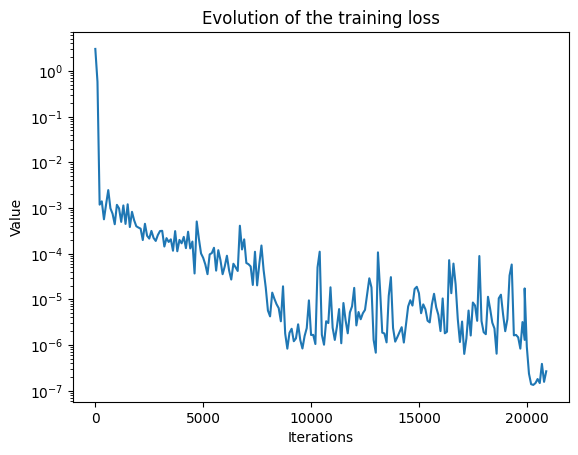

In [7]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

In [9]:
X_preds = X_pred[:500,:,0]

In [11]:
def forward_price(S, K, T, r, q=0):
    forward_price = S * np.exp((r - q) * T) - K
    return forward_price

def calculate_forward_prices(X_pred, time_array, K, r, T, q=0):
    rows, cols = X_pred.shape
    forward_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            forward_prices[i, j] = forward_price(S, K, time_to_maturity, r, q)
    
    return forward_prices

# Given parameters
K = 1.0     # Strike price
r = 0.02   # Risk-free interest rate
q = 0       # Dividend yield (assuming none)
T = 1       # Expiry time in years

Y_test = calculate_forward_prices(X_preds, t_test[0], K, r, T, q)

/tmp/ipykernel_586320/1179601216.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forward_prices[i, j] = forward_price(S, K, time_to_maturity, r, q)


In [12]:
errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

(1.3959291667532276e-06, 2.407271922008641e-06)

In [13]:
np.sqrt(errors.mean())

0.0011814944632765859

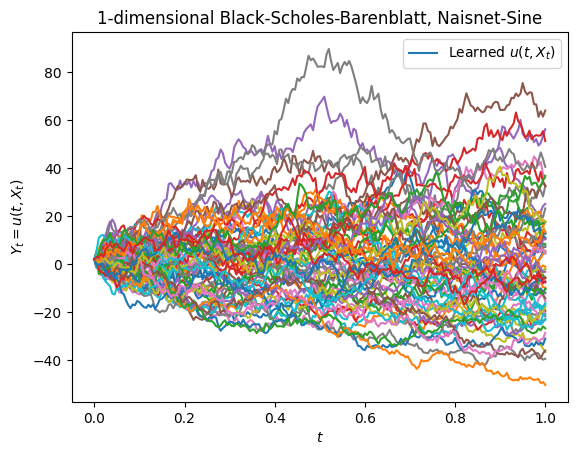

In [16]:
samples = 64

plt.figure()
plt.plot(t_test[0:1, :, 0].T, 100 * Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')


plt.plot(t_test[1:samples, :, 0].T, 100 * Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

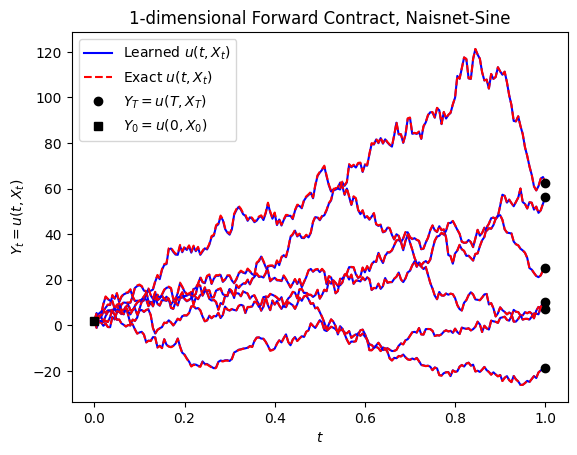

In [17]:
plt.figure()
plt.plot(t_test[0], 100 * Y_pred[0], 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0], 100 * Y_test[0], 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0, -1], 100 * Y_test[0, -1], 'ko', label='$Y_T = u(T,X_T)$')
for i in range(4, 100, 20):
    plt.plot(t_test[i], 100 * Y_pred[i], 'b')
    plt.plot(t_test[i], 100 * Y_test[i], 'r--')
    plt.plot(t_test[i, -1], 100 * Y_test[i, -1], 'ko')
plt.plot([0], 100 * Y_test[0,0], 'ks', label='$Y_0 = u(0,X_0)$')
plt.title(str(D) + '-dimensional Forward Contract, ' + model.mode + "-" + model.activation)
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.legend()
plt.show()

In [18]:
X_preds = np.sum(X_pred, axis=2) - 1
X_preds.shape

(8192, 201)

In [19]:
Y_preds = Y_pred.reshape(8192,201) * 100

In [20]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [21]:
epe = np.mean(np.maximum(Y_preds,0),axis=0)    
epe

array([ 1.9814606,  2.1351287,  2.324009 ,  2.517585 ,  2.663981 ,
        2.839384 ,  2.970079 ,  3.1001675,  3.1982193,  3.2927506,
        3.377789 ,  3.454346 ,  3.5266414,  3.6053944,  3.6973999,
        3.7912128,  3.8862464,  3.9489114,  4.023329 ,  4.1077433,
        4.1659718,  4.26133  ,  4.3490357,  4.4204006,  4.4983373,
        4.553182 ,  4.6190753,  4.6617646,  4.7454424,  4.7938933,
        4.868063 ,  4.945629 ,  4.997995 ,  5.068308 ,  5.142934 ,
        5.1679215,  5.208137 ,  5.253168 ,  5.2965345,  5.3577385,
        5.427178 ,  5.493304 ,  5.5463843,  5.594477 ,  5.6609445,
        5.724699 ,  5.7722373,  5.8115025,  5.8488994,  5.9147363,
        5.9559474,  6.0189133,  6.06551  ,  6.1149874,  6.1553273,
        6.2113495,  6.234398 ,  6.2824054,  6.3274517,  6.3855534,
        6.422665 ,  6.470195 ,  6.4992557,  6.5445356,  6.5925198,
        6.6489635,  6.700631 ,  6.7548313,  6.834541 ,  6.8868346,
        6.913691 ,  6.9490685,  6.9746585,  7.0092406,  7.0409

In [22]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([ 0.        , -0.1152252 , -0.287976  , -0.4530886 , -0.6233049 ,
       -0.7630723 , -0.90516585, -1.0228319 , -1.1355797 , -1.261396  ,
       -1.3526322 , -1.4507769 , -1.5527519 , -1.6532316 , -1.7536374 ,
       -1.8370289 , -1.9270005 , -2.0150158 , -2.0736074 , -2.154427  ,
       -2.242521  , -2.3039715 , -2.3819158 , -2.4486315 , -2.5154853 ,
       -2.5830007 , -2.6567748 , -2.7246978 , -2.8066611 , -2.880565  ,
       -2.9463384 , -3.0028155 , -3.0789514 , -3.1460674 , -3.21503   ,
       -3.270999  , -3.3141303 , -3.378553  , -3.4392705 , -3.5069427 ,
       -3.5611851 , -3.6041384 , -3.6865501 , -3.7258766 , -3.7640476 ,
       -3.8192089 , -3.8701744 , -3.9129107 , -3.9634264 , -4.01518   ,
       -4.069728  , -4.1197896 , -4.174908  , -4.227359  , -4.267279  ,
       -4.3115673 , -4.364491  , -4.43187   , -4.4746237 , -4.5144415 ,
       -4.561479  , -4.600875  , -4.6376905 , -4.6689606 , -4.7193446 ,
       -4.7558193 , -4.7996325 , -4.8387985 , -4.863674  , -4.90

In [23]:
from scipy.stats import norm

In [24]:
rv = norm()

In [25]:
x_init = 100.0
strike = 100.0
sigma = 0.25
r = 0.02

In [26]:
d1 = np.array([(-r * s + np.log(x_init/strike) + (r+sigma**2/2)*s)/sigma/np.sqrt(s) 
            for s in time_stamps[1:]])
d2 = np.array([d1[i]-sigma*np.sqrt(s) for i,s in enumerate(time_stamps[1:])])

In [27]:
epe_exact = x_init*rv.cdf(d1) - strike*np.exp(-r)*rv.cdf(d2)
epe_exact

array([ 1.68831187,  1.97752185,  2.19943162,  2.38650285,  2.55130958,
        2.70030033,  2.83730619,  2.96482309,  3.0845849 ,  3.19785396,
        3.30558346,  3.4085135 ,  3.50723319,  3.60221981,  3.69386703,
        3.78250306,  3.86840694,  3.95181593,  4.0329349 ,  4.1119431 ,
        4.18899627,  4.26423305,  4.33777561,  4.40973288,  4.48020345,
        4.54927537,  4.61702899,  4.68353615,  4.74886338,  4.81307133,
        4.87621506,  4.93834608,  4.99951121,  5.05975401,  5.11911484,
        5.17763136,  5.23533833,  5.29226842,  5.34845197,  5.40391754,
        5.45869192,  5.51280013,  5.56626602,  5.61911169,  5.67135775,
        5.7230248 ,  5.7741311 ,  5.82469462,  5.87473243,  5.92425985,
        5.97329278,  6.02184507,  6.06993084,  6.11756364,  6.16475526,
        6.21151806,  6.25786324,  6.30380197,  6.34934487,  6.39450137,
        6.4392809 ,  6.48369402,  6.52774785,  6.57145179,  6.61481467,
        6.65784299,  6.70054498,  6.74292772,  6.78499827,  6.82

In [28]:
ene_exact = x_init*rv.cdf(-d1) - strike*np.exp(-r)*rv.cdf(-d2) 
ene_exact

array([ 2.91820802e-01,  2.61081755e-03, -2.19298952e-01, -4.06370184e-01,
       -5.71176909e-01, -7.20167663e-01, -8.57173516e-01, -9.84690424e-01,
       -1.10445223e+00, -1.21772129e+00, -1.32545079e+00, -1.42838083e+00,
       -1.52710052e+00, -1.62208714e+00, -1.71373436e+00, -1.80237039e+00,
       -1.88827427e+00, -1.97168326e+00, -2.05280223e+00, -2.13181043e+00,
       -2.20886360e+00, -2.28410038e+00, -2.35764294e+00, -2.42960021e+00,
       -2.50007079e+00, -2.56914270e+00, -2.63689632e+00, -2.70340348e+00,
       -2.76873071e+00, -2.83293866e+00, -2.89608239e+00, -2.95821341e+00,
       -3.01937854e+00, -3.07962134e+00, -3.13898217e+00, -3.19749869e+00,
       -3.25520566e+00, -3.31213576e+00, -3.36831931e+00, -3.42378487e+00,
       -3.47855925e+00, -3.53266746e+00, -3.58613335e+00, -3.63897902e+00,
       -3.69122508e+00, -3.74289213e+00, -3.79399843e+00, -3.84456195e+00,
       -3.89459976e+00, -3.94412718e+00, -3.99316011e+00, -4.04171240e+00,
       -4.08979817e+00, -

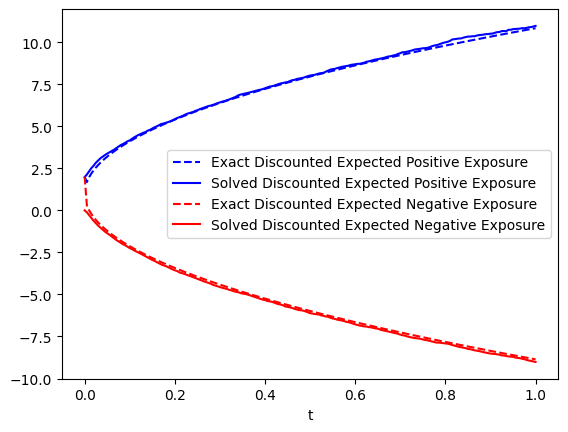

In [29]:
    fig = plt.figure()
    plt.plot(time_stamps,[2.0]+list(epe_exact),'b--',label='Exact Discounted Expected Positive Exposure')
    plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )

    plt.plot(time_stamps,[2.0]+list(ene_exact),'r--',label='Exact Discounted Expected Negative Exposure')
    plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')

    plt.xlabel('t')
    plt.legend()

    plt.show()

In [37]:
model.save_model("models/Forward1D2.pth")